# Machine learning: Predicción de estado de conservación de bombas de agua en Tanzania

## Análisis exploratorio inicial, por Francisco de Asís Borrego Díaz

En este Análisis exploratorio inicial se analiza una pequeña base de datos de bombas de agua públicas creada por el [Ministerio de agua de Tanzania](http://maji.go.tz/) a través de la organización [Taarifa](taarifa.org), donde las bombas pueden encontrarse en tres estados diferentes, funcionales, necesitan reparación o no funcionan. La idea proviene de la competición [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) de la web [Drivendata](https://www.drivendata.org).

Se dispone de una colección de bombas recolectada por diferentes organizaciones, la colección de datos es de más de 50000 bombas, pero sólo se disponen de datos de estado de unos 10000. Para cada bomba se conocen valores de estado, localización, instalación, edad, tipo y agua disponible.

En este EDA he realizado un análisis de las principales variables, intentando de manera inicial encontrar una relación a priori entre ellas y el estado.

# OBTENCIÓN DE LOS DATOS
DATASETS Y FUENTES ALTERNATIVAS DE DATOS
Incluye aquí una breve descripción del dataset o datasets de los que partirás para poder evaluar tu hipótesis.
También incluye el origen de estos datos y su fuente.

# describe la fuente de tus datos e incluye los links en Markdown

In [1]:
# Includes básicos

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from utils.funciones import *
import seaborn as sns

In [2]:
# Primer dataset de entrenamiento

# y_train es una lista con dos columnas, id y estado de la bomba
y_train_filename="datos/y_train_data.csv"
df_ytrain=pd.read_csv(y_train_filename)
df_ytrain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [3]:
# x_train es una lista con los datos de cada bomba, sin el estado.
x_train_filename="datos/x_train_data.csv"
df_xtrain=pd.read_csv(x_train_filename)
df_xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
# segundo dataset que se usará en el proceso de machine learning

x_test_filename="datos/x_test_data.csv"
df_xtest=pd.read_csv(x_test_filename)
df_xtest.shape

(14850, 40)

In [5]:
# Fusionamos nuestras dos primeras bases de datos
df_train=df_xtrain.set_index("id").join(df_ytrain,how="inner",sort=True)
df_train.shape
df_train["status_group"].value_counts(dropna=True)



functional                 25912
non functional             18148
functional needs repair     3432
Name: status_group, dtype: int64

In [6]:
df_train.dtypes.value_counts()

object     31
int64       7
float64     3
dtype: int64

In [7]:
# Fusionamos nuestras dos primeras bases de datos para lo que será los datos para la prueba, posteriormente
df_test=df_xtest.set_index("id").join(df_ytrain,how="inner")
df_test["status_group"].value_counts(dropna=False)

functional                 6347
non functional             4676
functional needs repair     885
Name: status_group, dtype: int64

In [8]:
df_train.shape

(47492, 41)

In [9]:
df_test.shape

(11908, 41)

In [10]:
df_train['status_group'].value_counts(dropna=False)

functional                 25912
non functional             18148
functional needs repair     3432
Name: status_group, dtype: int64

In [11]:
# Comprobamos valores duplicados.

df_train.drop_duplicates(inplace=True)

In [12]:
df_train.dropna(axis=0,subset=['status_group'],inplace=True)

In [13]:
# Valores inválidos
valores_nulos_show(df_train)


tipo datos  valores nulos  % nulos
funder                object           2896     6.10
installer             object           2912     6.13
subvillage            object            310     0.65
public_meeting        object           2638     5.55
scheme_management     object           3126     6.58
scheme_name           object          22503    47.38
permit                object           2439     5.14

In [14]:
df_train=fill_object_nan(df_train)
valores_nulos_show(df_train)    
# introducimos el texto "unkonwn" en cada uno de esos valores únicos

Empty DataFrame
Columns: [tipo datos, valores nulos, % nulos]
Index: []

## Análisis de columnas numéricas

In [15]:
df_train.describe()

# Tenemos 3 coordenadas de posición (x,y,z) en el mapa, 2 coordenadas de localización política, una inútil (num_private), una de población alrededor, otra de año de construcción
# y una técnica (amount_tsh). Se puede obtener también la fecha, desde donde viene la fecha de registro, pero no es útil.

amount_tsh    gps_height     longitude      latitude   num_private  \
count   47492.000000  47492.000000  47492.000000  4.749200e+04  47492.000000   
mean      321.619839    670.483113     34.073900 -5.709289e+00      0.483450   
std      3058.875078    694.169168      6.574296  2.940334e+00     13.101459   
min         0.000000    -90.000000      0.000000 -1.164944e+01      0.000000   
25%         0.000000      0.000000     33.085868 -8.538572e+00      0.000000   
50%         0.000000    372.000000     34.910935 -5.017494e+00      0.000000   
75%        25.000000   1321.000000     37.178734 -3.330187e+00      0.000000   
max    350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000   

        region_code  district_code    population  construction_year  \
count  47492.000000   47492.000000  47492.000000       47492.000000   
mean      15.331719       5.648783    180.113472        1302.240777   
std       17.660861       9.674385    477.018150         951.131485   
min        1.000000       0.000000      0.000000           0.000000   
25%        5.000000       2.000000      0.000000           0.000000   
50%       12.000000       3.000000     25.000000        1986.000000   
75%       17.000000       5.000000    213.000000        2004.000000   
max       99.000000      80.000000  30500.000000        2013.000000   

                 id  
count  47492.000000  
mean   37103.406553  
std    21495.186288  
min        0.000000  
25%    18442.750000  
50%    37031.500000  
75%    55734.750000  
max    74247.000000

In [16]:
# Introducimos columnas de información para el date recorded.
df_train["date_recorded"]=pd.to_datetime(df_train['date_recorded'],format='%Y-%m-%d',errors='coerce')
df_train["date_recorded_year"]=df_train["date_recorded"].dt.year
df_train["date_recorded_month"]=df_train["date_recorded"].dt.month

In [17]:
# Establecemos 1999 como año de cosntrucción de aquellos bombas que no se conocen.
df_train.construction_year=np.where(df_train.construction_year>0,df_train.construction_year,1999)
cuenta_valores_per(df_train,"construction_year",True)

                   valores_unicos       media
construction_year              54  879.481481


In [18]:
df_train.population=np.where(df_train.population>0,df_train.population,round(np.median(df_train.population.loc[df_train.population>0].mean()),0))
cuenta_valores_per(df_train,"population",True)

            valores_unicos      media
population             981  48.411825


In [19]:
# Agrupamos todas las variables categóricas.
resumen_tipos_unicos(df_train,tipos_col(df_train)["obj"])

valores_unicos  porcentaje_mayor_valor
funder                         1694.0               15.269940
installer                      1912.0               29.438642
wpt_name                      30643.0                6.015750
basin                             9.0               17.051293
subvillage                    17260.0                0.861198
region                           21.0                8.980460
lga                             125.0                4.268087
ward                           2084.0                0.530616
public_meeting                    3.0               85.780763
recorded_by                       1.0              100.000000
scheme_management                13.0               61.820938
scheme_name                    2536.0               47.382717
permit                            3.0               65.419439
extraction_type                  18.0               45.072854
extraction_type_group            13.0               45.072854
extraction_type_class             7.0               45.072854
management                       12.0               68.163059
management_group                  5.0               88.457003
payment                           7.0               42.617704
payment_type                      7.0               42.617704
water_quality                     8.0               85.660743
quality_group                     6.0               85.660743
quantity                          5.0               55.811505
quantity_group                    5.0               55.811505
source                           10.0               28.566917
source_type                       7.0               28.566917
source_class                      3.0               76.975069
waterpoint_type                   7.0               48.027036
waterpoint_type_group             6.0               58.279289
status_group                      3.0               54.560768

In [20]:
for col in tipos_col(df_train)["obj"]:
    df_train[col] = agrupa_categoricas(df_train,col,9,0)

resumen_tipos_unicos(df_train,tipos_col(df_train)["obj"])

valores_unicos  porcentaje_mayor_valor
funder                           10.0               59.024678
installer                        10.0               51.669755
wpt_name                         10.0               86.591426
basin                             9.0               17.051293
subvillage                       10.0               94.723322
region                           10.0               39.524552
lga                              10.0               80.556725
ward                             10.0               96.593110
public_meeting                    3.0               85.780763
recorded_by                       1.0              100.000000
scheme_management                10.0               61.820938
scheme_name                      10.0               47.382717
permit                            3.0               65.419439
extraction_type                   9.0               45.072854
extraction_type_group             9.0               45.072854
extraction_type_class             7.0               45.072854
management                        9.0               68.163059
management_group                  5.0               88.457003
payment                           7.0               42.617704
payment_type                      7.0               42.617704
water_quality                     8.0               85.660743
quality_group                     6.0               85.660743
quantity                          5.0               55.811505
quantity_group                    5.0               55.811505
source                            9.0               28.566917
source_type                       7.0               28.566917
source_class                      3.0               76.975069
waterpoint_type                   7.0               48.027036
waterpoint_type_group             6.0               58.279289
status_group                      3.0               54.560768

In [21]:
#Substutimos valores extra por "desconocidos"
df_train.replace("other","unknown",inplace=True)


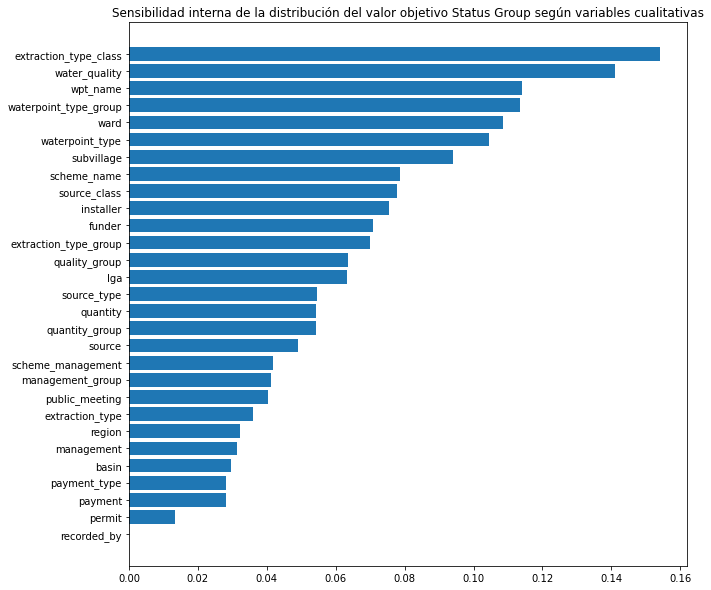

In [22]:
figura=variabilidad(df_train,"status_group").transpose().sort_values(by="status_group")
plt.figure(figsize=[10,10])
plt.barh(figura.index, figura.status_group)
plt.title("Sensibilidad interna de la distribución del valor objetivo Status Group según variables cualitativas")
plt.show()

## Estudio de las variables
 Muchas de las variables son redundantes. Referirse al EDA_ampliado donde está detallado una por una.

## status_group

variable objetivo cualitativa, en tres estados

In [23]:
cuenta_valores_per(df_train,"status_group")

              valores_unicos         media
status_group               3  15830.666667


Text(0.5, 1.0, 'Distribución de estado de las bombas')

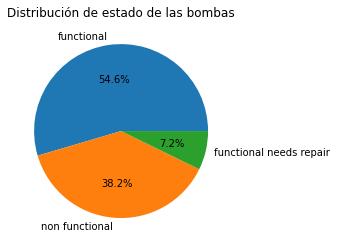

In [24]:
def func(pct):
  return "{:1.1f}%".format(pct)
plt.pie(df_train.status_group.value_counts(),labels=df_train.status_group.value_counts().index,autopct=lambda pct: func(pct))
plt.title("Distribución de estado de las bombas")

## status_group_simpl

df_train['status_group_simpl'] = 'functional' o ' non functional', donde este útlimo agrupa también 'functional needs repair'

In [25]:
df_train['status_group_simpl']=df_train['status_group']
df_train['status_group_simpl']=np.where(df_train['status_group_simpl']=='functional','functional','non functional')

Text(0.5, 1.0, 'Distribución de estado de las bombas')

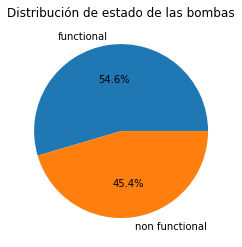

In [26]:
def func(pct):
  return "{:1.1f}%".format(pct)
plt.pie(df_train.status_group_simpl.value_counts(),labels=df_train.status_group_simpl.value_counts().index,autopct=lambda pct: func(pct))
plt.title("Distribución de estado de las bombas")

In [27]:
cuenta_valores_per(df_train,"status_group_simpl")

                    valores_unicos    media
status_group_simpl               2  23746.0


## 1. id

Es una variable con números de identificación

## 2. amount_tsh

amount_tsh - Total static head (o altura estática del pozo). Indica la presión del agua (imagen)

<AxesSubplot:ylabel='Frequency'>

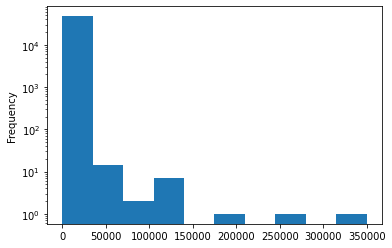

In [28]:
df_train['amount_tsh'].plot(kind='hist',logy=True)

<AxesSubplot:xlabel='status_group', ylabel='amount_tsh'>

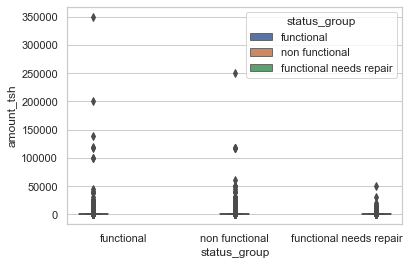

In [29]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=df_train, hue="status_group", x="status_group" ,y="amount_tsh")

In [30]:
df_train["amount_tsh"].describe()

count     47492.000000
mean        321.619839
std        3058.875078
min           0.000000
25%           0.000000
50%           0.000000
75%          25.000000
max      350000.000000
Name: amount_tsh, dtype: float64

## 3. date_recorded

Fecha en que introdujo el registro en la base de datos. No será relevante

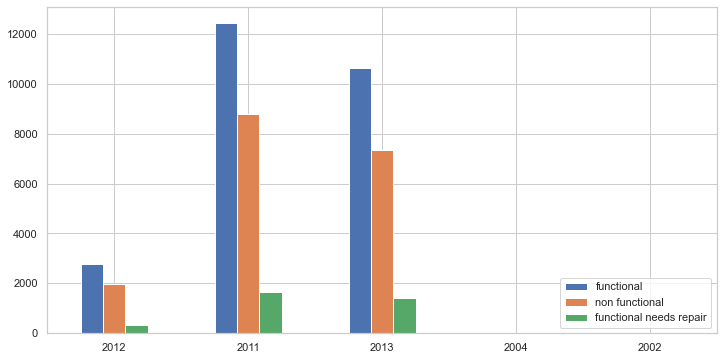

In [31]:
plot_bar_cat(df_train,"date_recorded_year","status_group",12,6,False)

## 4. funder

Quién instaló el pozo

In [32]:
cuenta_valores_per(df_train,"funder")

        valores_unicos        media
funder               9  5276.888889


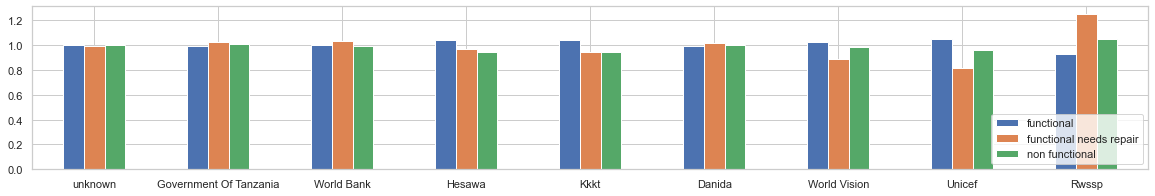

In [33]:
plot_bar_cat(df_train,"funder","status_group",20,3,True)
# Rwssp muestra mayor frecuencia a necesitar reparaciones.

## 6 installer

quién instaló el conjunto de datos

In [34]:
cuenta_valores_per(df_train,"installer")

           valores_unicos        media
installer               9  5276.888889


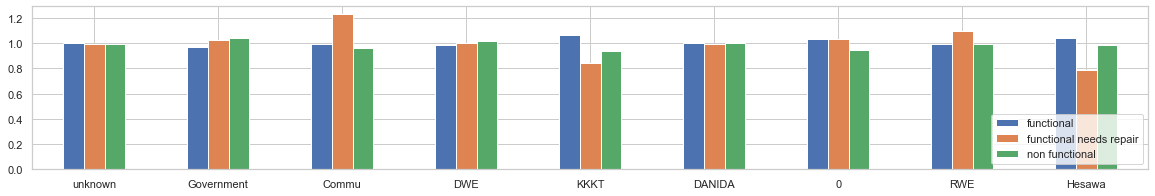

In [35]:
plot_bar_cat(df_train,"installer","status_group",20,3,True)
# Commu muestra mayor frecuencia a necesitar reparaciones. Hesawa menos.

## 7. longiture, latitude

coordenadas de los pozos. Muchos pozos no poseen datos de posición

In [36]:
" Existen muchos valores con longitud y latitud cero. sin embargo, tienen una región asignada. Por ello, vamos a asignarles valores al azar entre los puntos de cada región"

df_train_local=df_train.loc[df_train["longitude"]!=0]
#regiones_medias=df_train_local[["gps_height","longitude","latitude","region_code"]].groupby(by=["region_code"]).mean().add_suffix("_mean")
#regiones_medianas=df_train_local[["gps_height","longitude","latitude","region_code"]].groupby(by=["region_code"]).median().add_suffix("_median")
regiones_maximas=df_train_local[["gps_height","longitude","latitude","region_code"]].groupby(by=["region_code"]).max().add_suffix("_max")
regiones_minimas=df_train_local[["gps_height","longitude","latitude","region_code"]].groupby(by=["region_code"]).min().add_suffix("_min")
#regiones=regiones_medias.join(regiones_medianas).join(regiones_maximas).join(regiones_minimas)
regiones=regiones_maximas.join(regiones_minimas)
regiones

gps_height_max  longitude_max  latitude_max  gps_height_min  \
region_code                                                                
1                         0      36.923843     -4.335202               0   
2                      2770      37.402648     -1.822960             594   
3                      1888      38.111964     -2.961616             337   
4                      2024      39.172881     -4.372967             -39   
5                      1665      38.484931     -5.816946               0   
6                       399      39.878767     -5.990801             -55   
7                       151      39.537132     -6.576367             -63   
8                       461      38.887173    -10.020672             220   
9                       471      40.231707    -10.266446             -90   
10                     1840      37.962002     -9.527207             294   
11                     2559      36.522248     -3.564862               0   
12                        0      34.875232     -7.090603               0   
13                     1754      35.344760     -3.962064             830   
14                        0      34.046206     -3.914961               0   
15                     2222      32.492944     -5.502425             743   
16                     1760      31.190741     -2.862308             768   
17                     1434      34.758439     -2.832405               0   
18                       35      39.889880     -0.998464               0   
19                     1328      33.756895     -1.714486               0   
20                     1854      35.221310     -1.042375            1127   
21                     2253      37.877825     -3.475012             561   
24                     1861      35.924154     -3.157267            1027   
40                       34      39.217993     -7.001266              34   
60                      382      39.873861     -6.951109             -57   
80                      851      39.963363     -8.284239             -51   
90                      879      39.446226    -10.360023              19   
99                      249      40.345193    -10.128340             -50   

             longitude_min  latitude_min  
region_code                               
1                35.147485     -7.300482  
2                34.986908     -3.766608  
3                36.923908     -4.606940  
4                37.125294     -5.991881  
5                35.365377     -9.191424  
6                37.917781     -7.903910  
7                39.039088     -7.162921  
8                37.907891    -10.637053  
9                39.418185    -10.946096  
10               34.607742    -11.649440  
11               33.196860    -10.524710  
12               32.144579     -9.700965  
13               33.520271     -6.947457  
14               31.216732     -6.916830  
15               30.306921     -8.990321  
16               29.607122     -5.416756  
17               31.454726     -4.249324  
18               30.435203    -10.144198  
19               32.046458     -3.424444  
20               33.207952     -2.442619  
21               34.871954     -5.952854  
24               35.293842     -3.669964  
40               39.217993     -7.001266  
60               38.236495     -8.477555  
80               37.404880    -10.565007  
90               38.013947    -11.366974  
99               39.697822    -10.771303

In [37]:
#inputamos valores de colocación basados en región en una nueva variable (df_train_one)
df_train_zero=df_train.loc[df_train["longitude"]==0]
print(f"número de bombas con coordenadas cero: {df_train_zero.shape[0]}")
var_imputables=["gps_height","longitude","latitude"]
df_train_loc_zero=df_train_zero[["region_code"]+var_imputables]
for region in regiones.index:
    for variable in var_imputables:
        #media=regiones.loc[[region]][variable+"_mean"].values[0]
        min=regiones.loc[[region]][variable+"_min"].values[0]
        max=regiones.loc[[region]][variable+"_max"].values[0]
        tam=df_train_zero[variable].loc[df_train_zero["region_code"]==region].shape
        #print(df_train_zero.loc[df_train_zero["region_code"]==region].shape[0])
        valores=np.random.random_sample(size=tam)*(max-min)+np.ones(tam)*min
        df_train_zero[variable].loc[df_train_zero["region_code"]==region]=valores
df_train_loc_imput=df_train_zero[["region_code"]+var_imputables]
#df_train_zero["long_falsa"]=np.random.normal(1, 1, size=df_train_zero.shape[0])
df_train_one=df_train
df_train_one.loc[df_train_zero.index, var_imputables]=df_train_zero[var_imputables]


número de bombas con coordenadas cero: 1452


C:\Users\Rucufuto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Rucufuto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()


In [38]:
regiones.loc[[17]+[19]]

gps_height_max  longitude_max  latitude_max  gps_height_min  \
region_code                                                                
17                     1434      34.758439     -2.832405               0   
19                     1328      33.756895     -1.714486               0   

             longitude_min  latitude_min  
region_code                               
17               31.454726     -4.249324  
19               32.046458     -3.424444

In [39]:
df_train_loc_zero.head(2)

region_code  gps_height  longitude      latitude
15           19           0        0.0 -2.000000e-08
50           19           0        0.0 -2.000000e-08

In [40]:
df_train_loc_imput.head(2)

region_code  gps_height  longitude  latitude
15           19  133.589805  32.952722 -2.241199
50           19  806.831768  33.087487 -3.036713

In [41]:
# inputamos valores aleatorios de df_train_zero 

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


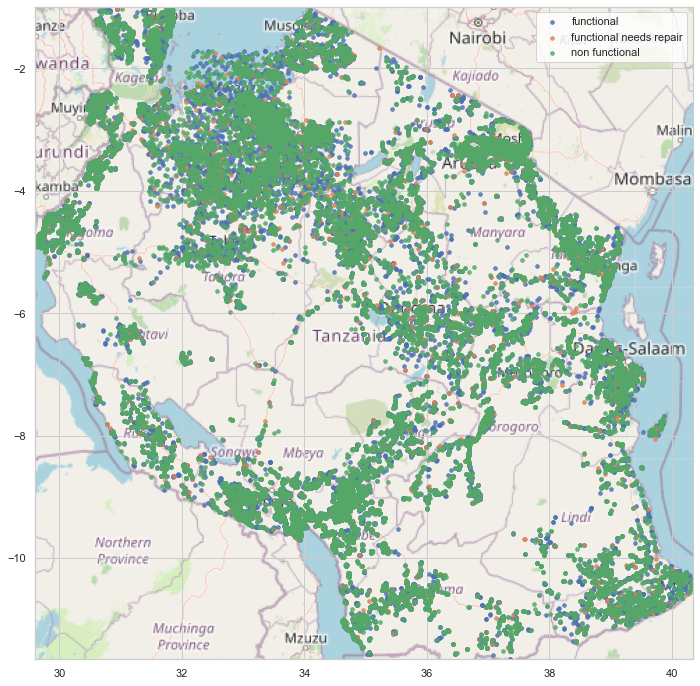

In [42]:
ruta_imagen_tanzania="imagenes/OSM_tz_mapa.png"
grafica_tanzania(df_train_one,ruta_imagen_tanzania,"status_group")
# A priori no parece haber patrón en la posición de los pozos y el estado.

## 5. GPS height

altura del gps en metros

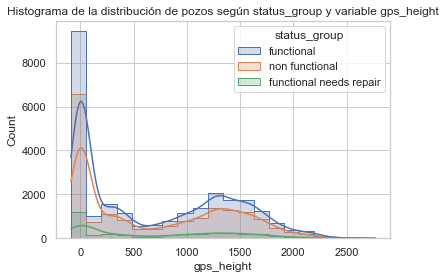

In [43]:
hist_var(df_train_one,"status_group","gps_height")

<AxesSubplot:xlabel='status_group', ylabel='gps_height'>

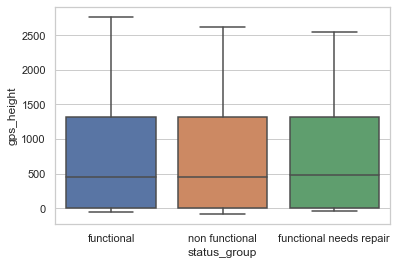

In [44]:
sns.boxplot(data=df_train_one,  x="status_group" ,y="gps_height")
# No parece haber relación

## 9 wpt_name

Nombre del pozo si es que tiene uno

In [45]:
cuenta_valores_per(df_train,"wpt_name")
# No es útil.

          valores_unicos   media
wpt_name              10  4749.2


## 11 basin

A qué fuente de agua pertenece el pozo

In [46]:
cuenta_valores_per(df_train,"basin")

       valores_unicos        media
basin               9  5276.888889


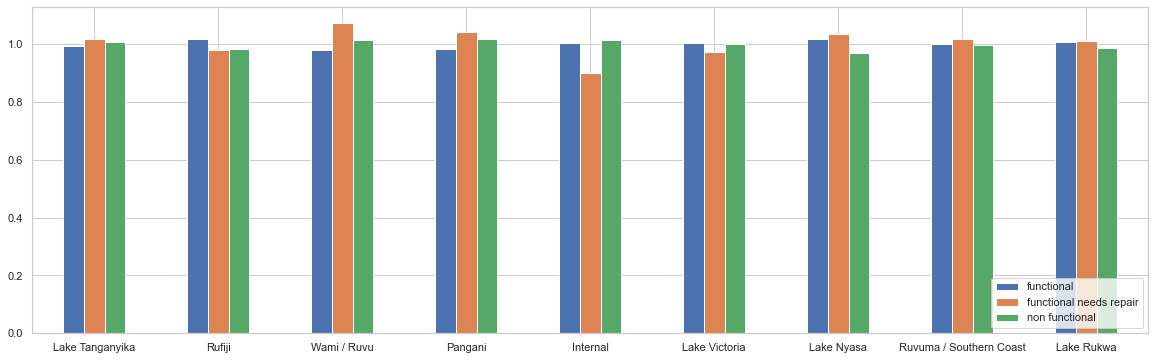

In [47]:
plot_bar_cat(df_train,"basin","status_group",20,6, True)

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


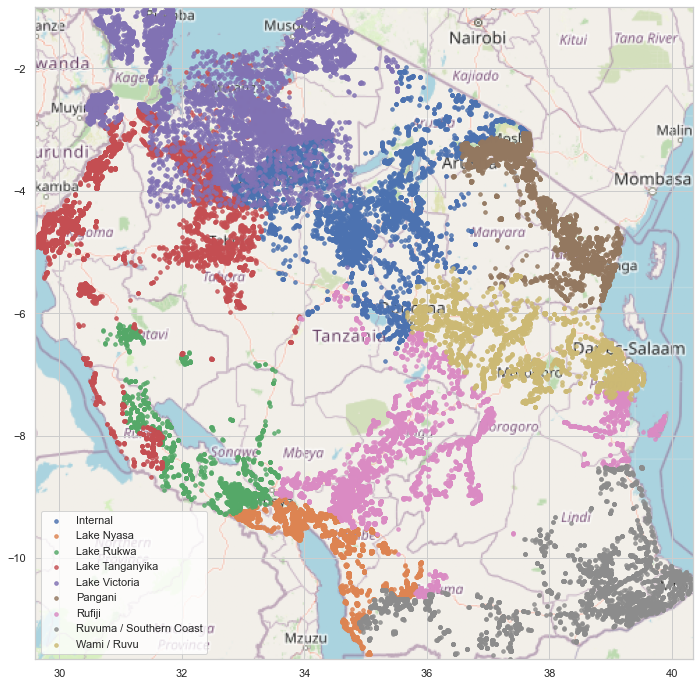

In [48]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"basin")
# Es un valor puramente geográfico. No será relevante.

Subvillage, region, region code, district code, lga y ward son relativos a la localización. se ignorarán.

In [49]:
cts=pd.DataFrame(df_xtest['region_code'].value_counts().sort_index()).rename(columns={"region_code": "region_code"})
ctr=pd.DataFrame(df_xtrain['region_code'].value_counts().sort_index()).rename(columns={"region_code": "region_code"})
ct=cts.join(ctr,how='outer',lsuffix='_test',rsuffix='_train')
ct

region_code_test  region_code_train
1              578.0               2201
2              685.0               3024
3             1115.0               4379
4              632.0               2513
5             1039.0               4040
6              423.0               1609
7              215.0                805
8               75.0                300
9              109.0                390
10             666.0               2640
11            1308.0               5300
12            1120.0               4639
13             443.0               2093
14             509.0               1979
15             434.0               1808
16             717.0               2816
17            1323.0               5011
18             859.0               3324
19             777.0               3047
20             482.0               1969
21             389.0               1583
24              76.0                326
40               NaN                  1
60             273.0               1025
80             298.0               1238
90             216.0                917
99              89.0                423

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


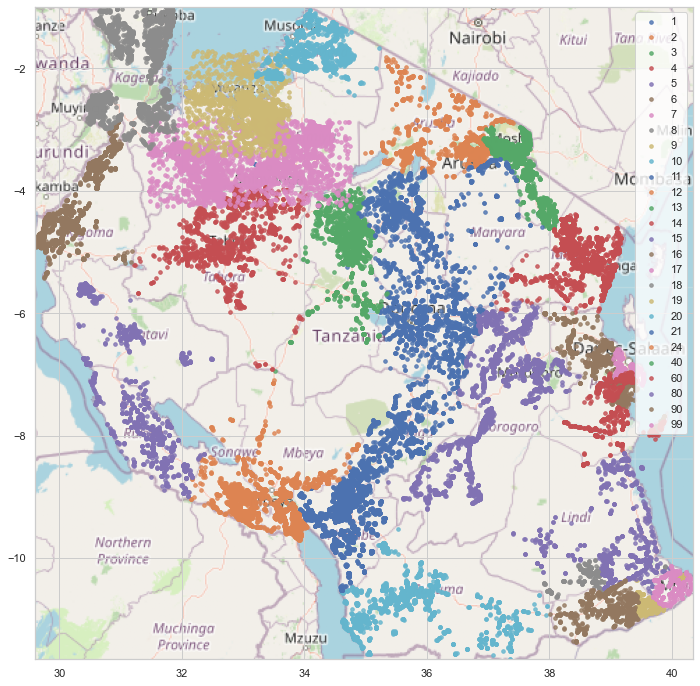

In [50]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"region_code")

## 18 population - 

Population around the well 

Podría ser interesante para ver si hay relación. Podría crearse hasta una medida extra de "población*años instalado" y comparar con el descarte


In [51]:
df_train["population"].describe()
# La mitad de los pozos sólo sirven a 20 personas o menos. Esto podría indicar si están averiados o no.

count    47492.000000
mean       281.142592
std        457.531223
min          1.000000
25%        100.000000
50%        281.000000
75%        281.000000
max      30500.000000
Name: population, dtype: float64

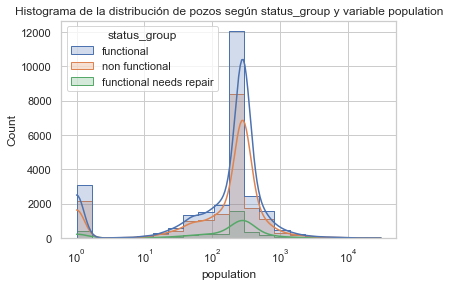

In [52]:
#sns.histplot(x=df_train['population'],log_scale=False, kde=True) 
hist_var(df_train,"status_group","population",bins=20,modo_seaborn=True,log_scale=True)

## 19 public_meeting

Columna booleana. No tengo claro qué significa. La mayoría de valores son ciertos.

In [53]:
cuenta_valores_per(df_train,"public_meeting",False)

total          %
True     40739  85.780763
False     4115   8.664617
unknown   2638   5.554620

In [54]:
tabl_contingencia(df_train,"public_meeting","status_group",False)

functional  non functional  functional needs repair
unknown        1445            1020                      173
True          22199           15556                     2984
False          2268            1572                      275

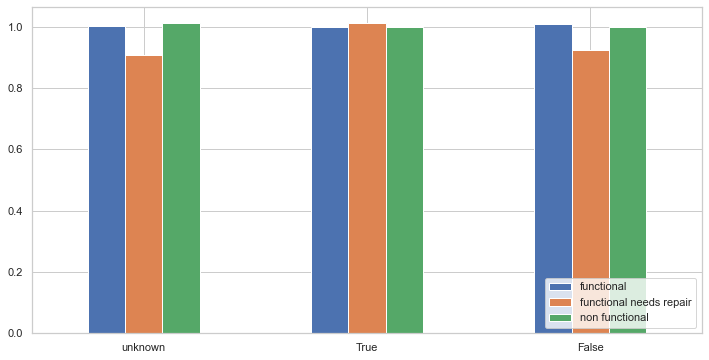

In [55]:
plot_bar_cat(df_train,"public_meeting","status_group",12,6,True)

## 21 scheme management

Quién instaló la bomba

In [56]:
cuenta_valores_per(df_train,"scheme_management",False)

total          %
VWC               29360  61.820938
WUG                4209   8.862545
unknown            3862   8.131896
Water authority    2543   5.354586
WUA                2301   4.845027
Water Board        2196   4.623937
Parastatal         1329   2.798366
Private operator    863   1.817148
Company             829   1.745557

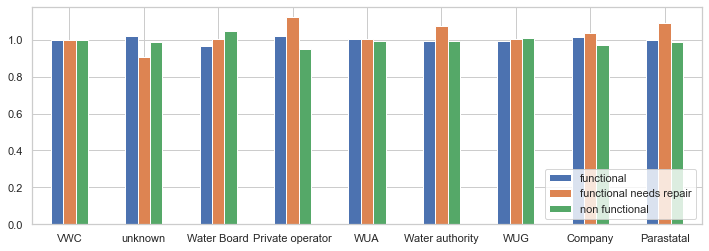

In [57]:
plot_bar_cat(df_train,"scheme_management","status_group",12,4,True)

## 23 permit 
- Si se permite el pozo

In [58]:
cuenta_valores_per(df_train,"permit",False)

total          %
True     31069  65.419439
False    13984  29.444959
unknown   2439   5.135602

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


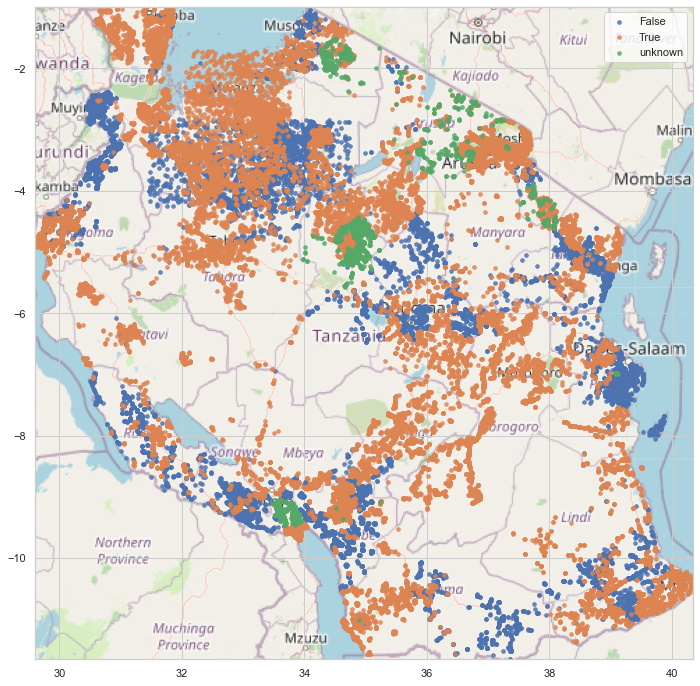

In [59]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"permit")
# Se observa de nuevo que los puntos tienen fuerte dependencia de la localización. No parece a prioru ser interesante.

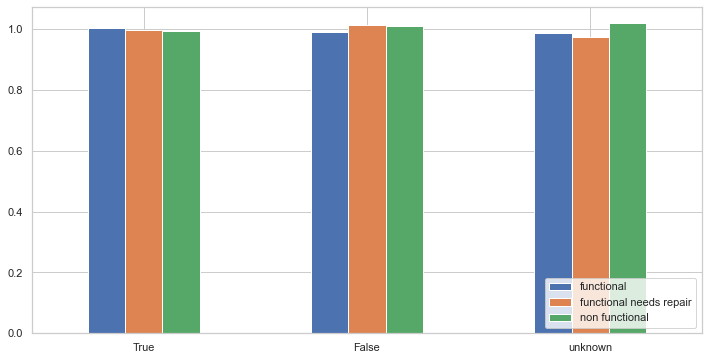

In [60]:
plot_bar_cat(df_train,"permit","status_group",12,6,True)
# No parece haber especial incidencia

## 24 construction_year 
- Year the waterpoint was constructed

In [61]:
cuenta_valores_per(df_train,"construction_year")

                   valores_unicos       media
construction_year              54  879.481481


## 25 extraction_type 
- The kind of extraction the waterpoint uses

In [62]:
cuenta_valores_per(df_train,"extraction_type",False)

total          %
gravity        21406  45.072854
nira/tanira     6582  13.859176
unknown         6114  12.873747
submersible     3799   7.999242
swn 80          2913   6.133665
mono            2293   4.828182
india mark ii   1884   3.966984
afridev         1376   2.897330
ksb             1125   2.368820

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


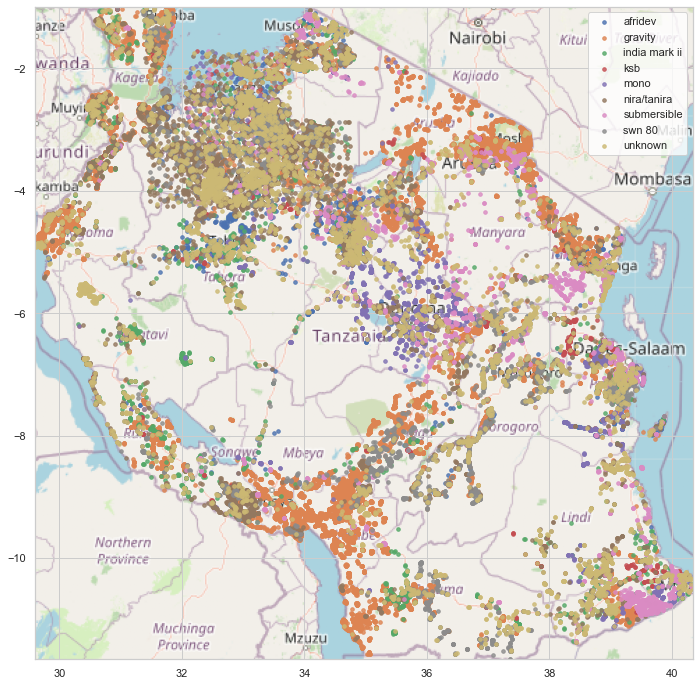

In [63]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"extraction_type")

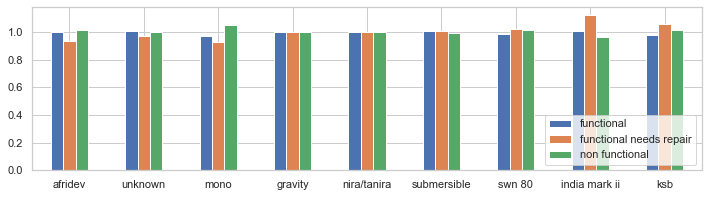

In [64]:
plot_bar_cat(df_train,"extraction_type","status_group",12,3,True)

## 27. extraction_type_class - The kind of extraction the waterpoint uses

8 valores. Este tipo puede ser interesante.

In [65]:
cuenta_valores_per(df_train,"extraction_type_class")

                       valores_unicos        media
extraction_type_class               7  6784.571429


Text(0.5, 1.0, 'Frecnuencia relativa de los principales valores de extraction_class_type frente a status_group')

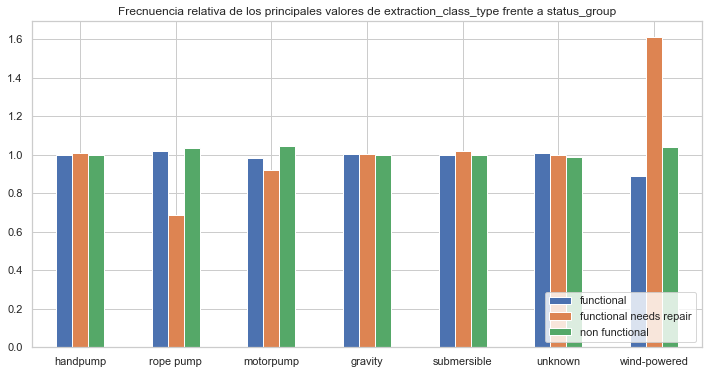

In [66]:
plot_bar_cat(df_train,"extraction_type_class","status_group",12,6,True)
plt.title("Frecnuencia relativa de los principales valores de extraction_class_type frente a status_group")

## 28. management - How the waterpoint is managed
Este valor al estar reducido puede ser interesante, pero la mayoría de valores pertenecen a vwc.

In [67]:
cuenta_valores_per(df_train,"management")

            valores_unicos        media
management               9  5276.888889


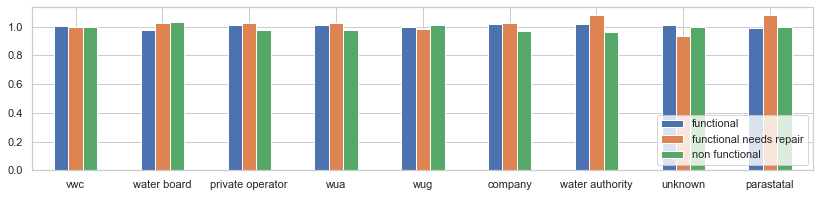

In [68]:
plot_bar_cat(df_train,"management","status_group",14,3,True)

[29.6071219, 40.34519307, -11.64944018, -0.99846435]


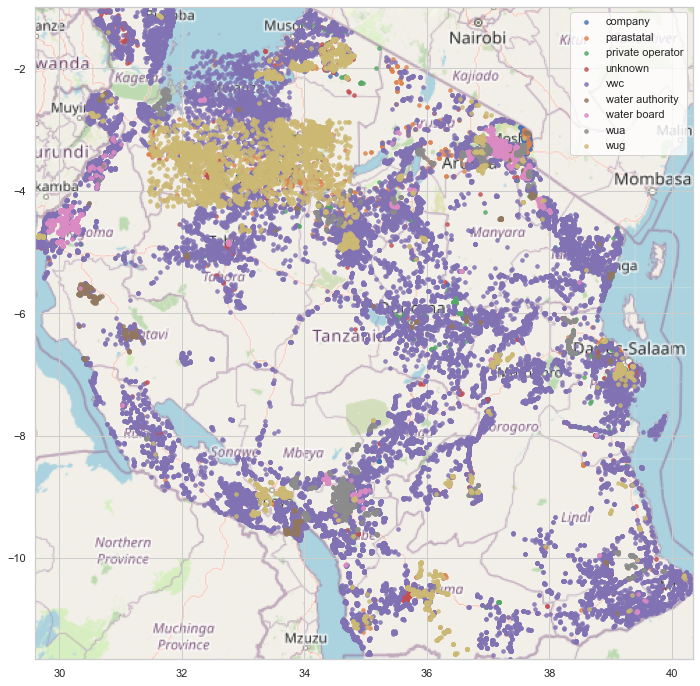

In [69]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"management")
# Fuerte dependencia de la región en aquellos valores que no son "company"

## 30. payment - What the water costs
## 31. payment_type - What the water costs

Son iguales. No muestra a priori mucha relevancia.

In [70]:
cuenta_valores_per(df_train,"payment")

         valores_unicos        media
payment               6  7915.333333


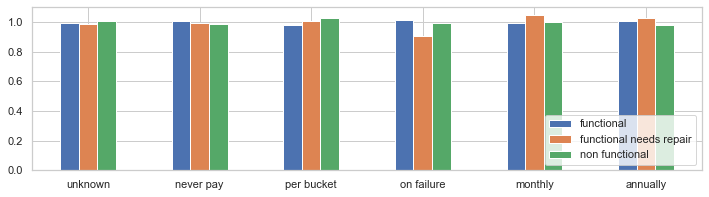

In [71]:
plot_bar_cat(df_train,"payment_type","status_group",12,3,True)

## 32. water_quality - The quality of the water
El 85% de los pozos son de tipo blando. Mejor usar quality_group

In [72]:
cuenta_valores_per(df_train,"water_quality")

               valores_unicos   media
water_quality               8  5936.5


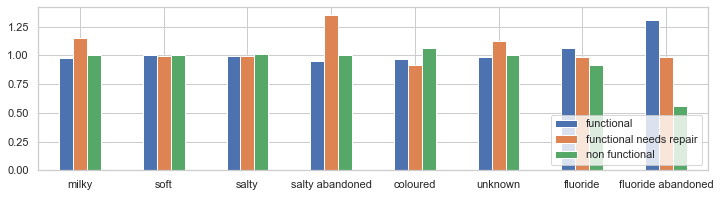

In [73]:
plot_bar_cat(df_train,"water_quality","status_group",12,3,True)
# Fluoride abandoned es testimonial por su escasa presencia. Por esta razón se emplea el siguiente grupo.

## 33. quality_group - The quality of the water

Este grupo es igual que water_quality, pero reune los dos de flouride. Es preferible

In [74]:
cuenta_valores_per(df_train,"quality_group")

               valores_unicos        media
quality_group               6  7915.333333


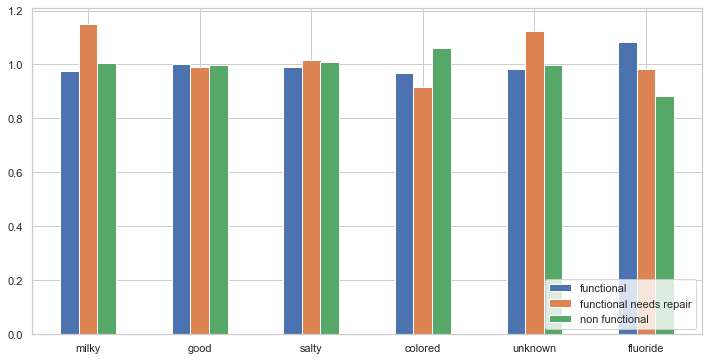

In [75]:
plot_bar_cat(df_train,"quality_group","status_group",12,6,True)

## 34. quantity - The quantity of water
## 35. quantity_group - The quantity of water
Ambos indican si la cantidad de agua es suficiente en una variable categórica. son la misma variable.

In [76]:
cuenta_valores_per(df_train,"quantity_group")

                valores_unicos   media
quantity_group               5  9498.4


[29.6071219, 40.34519307, -11.64944018, -0.99846435]


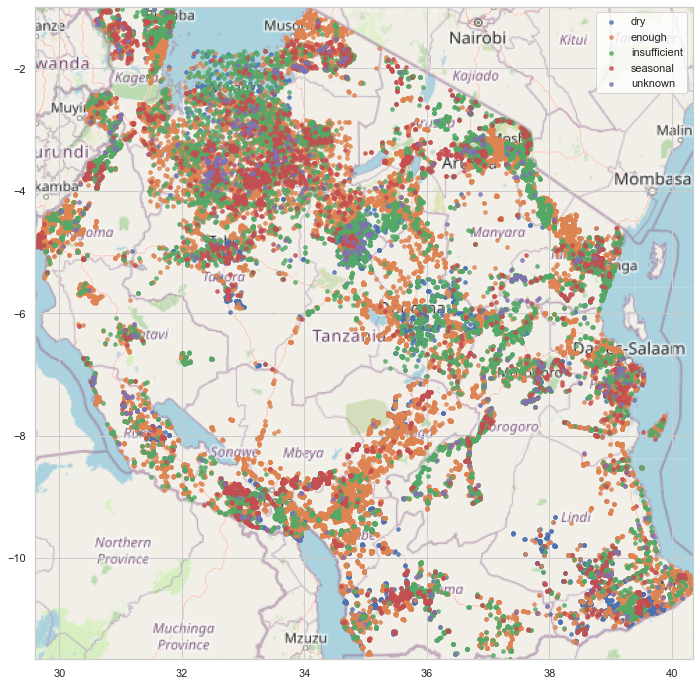

In [77]:
grafica_tanzania(df_train,ruta_imagen_tanzania,"quantity_group")

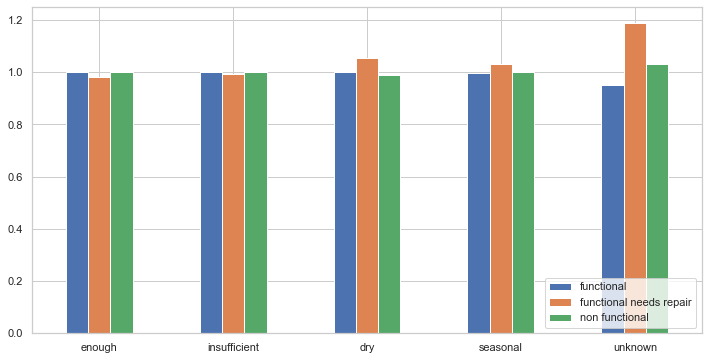

In [78]:
plot_bar_cat(df_train,"quantity_group","status_group",12,6,True)

## 36. source - The source of the water
## 37 soruce_type (mejor que el anterior)
## 38. source_class - The source of the water (Este indica que si es subterranea o superficie. Viene de source.)

In [79]:
cuenta_valores_per(df_train,"source")

        valores_unicos        media
source               9  5276.888889


In [80]:
cuenta_valores_per(df_train,"source_type")

             valores_unicos        media
source_type               7  6784.571429


In [81]:
cuenta_valores_per(df_train,"source_class")

              valores_unicos         media
source_class               3  15830.666667


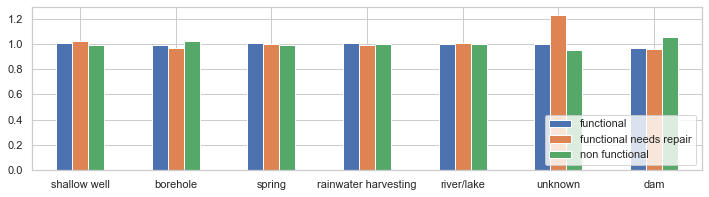

In [82]:
plot_bar_cat(df_train,"source_type","status_group",12,3,True)

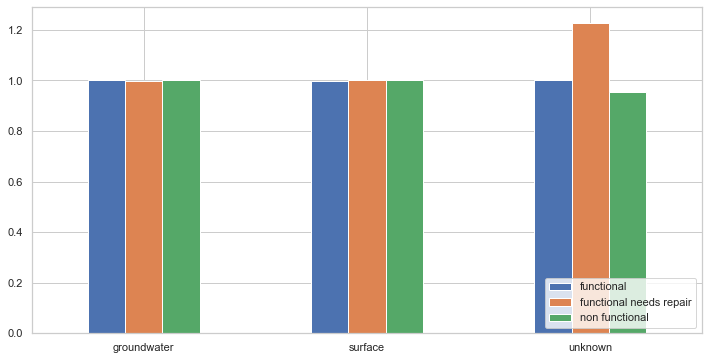

In [83]:
plot_bar_cat(df_train,"source_class","status_group",12,6,True)

## 39. waterpoint_type - The kind of waterpoint
## 40. waterpoint_type_group - The kind of waterpoint (Éste es mejor)
La variable indica el tipo de tecnología del pozo

In [84]:
cuenta_valores_per(df_train,"waterpoint_type_group")

                       valores_unicos        media
waterpoint_type_group               6  7915.333333


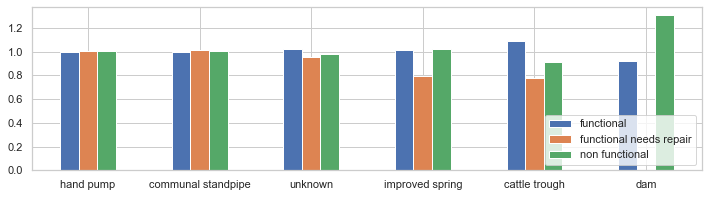

In [85]:
plot_bar_cat(df_train,"waterpoint_type_group","status_group",12,3,True)

# Resulmen de variables relevantes
De texto.

List:
    40. waterpoint_type (tecnología de pozos, 5 tipos)
    38. source_type
    35. quality_group
    33. quantity_group
    31. payment_type
    27. extraction_type_class (tecnología de extracción)
    24. construcion_year
    23. permit
    22. scheme_name
    11-17 valores relativos a la localización. No son relevantes
    4. funder (quién instaló)
    6. installer (organización que instaló)

Numéricas
['amount_tsh', 2. Cantidad de agua dsponible
 'gps_height', 5. Altura en metros
 'longitude', 6- latitud
 'latitude', 7. longitud
 'region_code',  de localización, es categórico
 'district_code', de localización, es categórico
 'population', 18. Población alrededor. La mayoría son cero.
 'construction_year', 24. FEcha construcción-
 'id', clave
 'edad_years', Derivados del valor 24.
 'date_recorded_year',
 'date_recorded_month']
    

## Variables auxiliares:

Distancia pozo más cercano

In [86]:
df_dist=df_train_one
df_dist["dist_mas_cercano"]=lugar_mas_cercano(df_dist[["longitude","latitude","region_code"]],"gps",True)


método nuevo, distancia máxmimo 500 km
1 de 47492, van 0.002%
2 de 47492, van 0.004%
3 de 47492, van 0.006%
4 de 47492, van 0.008%
5 de 47492, van 0.011%
6 de 47492, van 0.013%
7 de 47492, van 0.015%
8 de 47492, van 0.017%
9 de 47492, van 0.019%
10 de 47492, van 0.021%
11 de 47492, van 0.023%
12 de 47492, van 0.025%
13 de 47492, van 0.027%
14 de 47492, van 0.029%
15 de 47492, van 0.032%
16 de 47492, van 0.034%
17 de 47492, van 0.036%
18 de 47492, van 0.038%
19 de 47492, van 0.04%
20 de 47492, van 0.042%
21 de 47492, van 0.044%
22 de 47492, van 0.046%
23 de 47492, van 0.048%
24 de 47492, van 0.051%
25 de 47492, van 0.053%
26 de 47492, van 0.055%
27 de 47492, van 0.057%
28 de 47492, van 0.059%
29 de 47492, van 0.061%
30 de 47492, van 0.063%
31 de 47492, van 0.065%
32 de 47492, van 0.067%
33 de 47492, van 0.069%
34 de 47492, van 0.072%
35 de 47492, van 0.074%
36 de 47492, van 0.076%
37 de 47492, van 0.078%
38 de 47492, van 0.08%
39 de 47492, van 0.082%
40 de 47492, van 0.084%
41 de 47492,

In [87]:
df_train_one['dist_mas_cercano']=df_dist["dist_mas_cercano"]

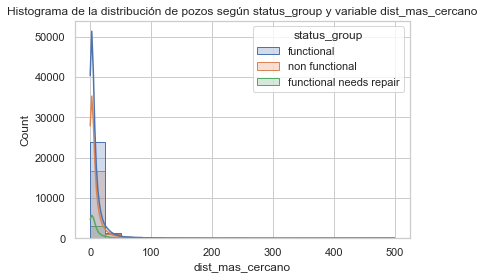

In [88]:
hist_var(df_train_one,"status_group","dist_mas_cercano")

<AxesSubplot:xlabel='status_group', ylabel='dist_mas_cercano'>

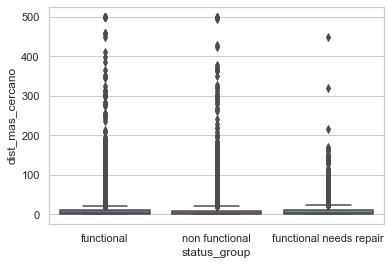

In [89]:
sns.boxplot(data=df_train_one,  x="status_group" ,y="dist_mas_cercano")

## Pairplot

In [90]:
"""lista_numericas=['amount_tsh', 'construction_year', 
'longitude', 
'latitude', 'gps_height',
'population', 
"dist_mas_cercano"] """

lista_numericas=['amount_tsh', 'construction_year', 
'longitude', 
'latitude', 'gps_height',
'population','dist_mas_cercano'
]

lista_categoricas=["waterpoint_type","source_type","quality_group","quantity_group","payment_type","extraction_type_class","permit","scheme_name","funder","installer"]

listas_targets=['status_group',"status_group_simpl"]

 # Realmente no hay apenas variables numéricas a priori interesantes. La mayoría del trabajo se hará con las variables categóricas

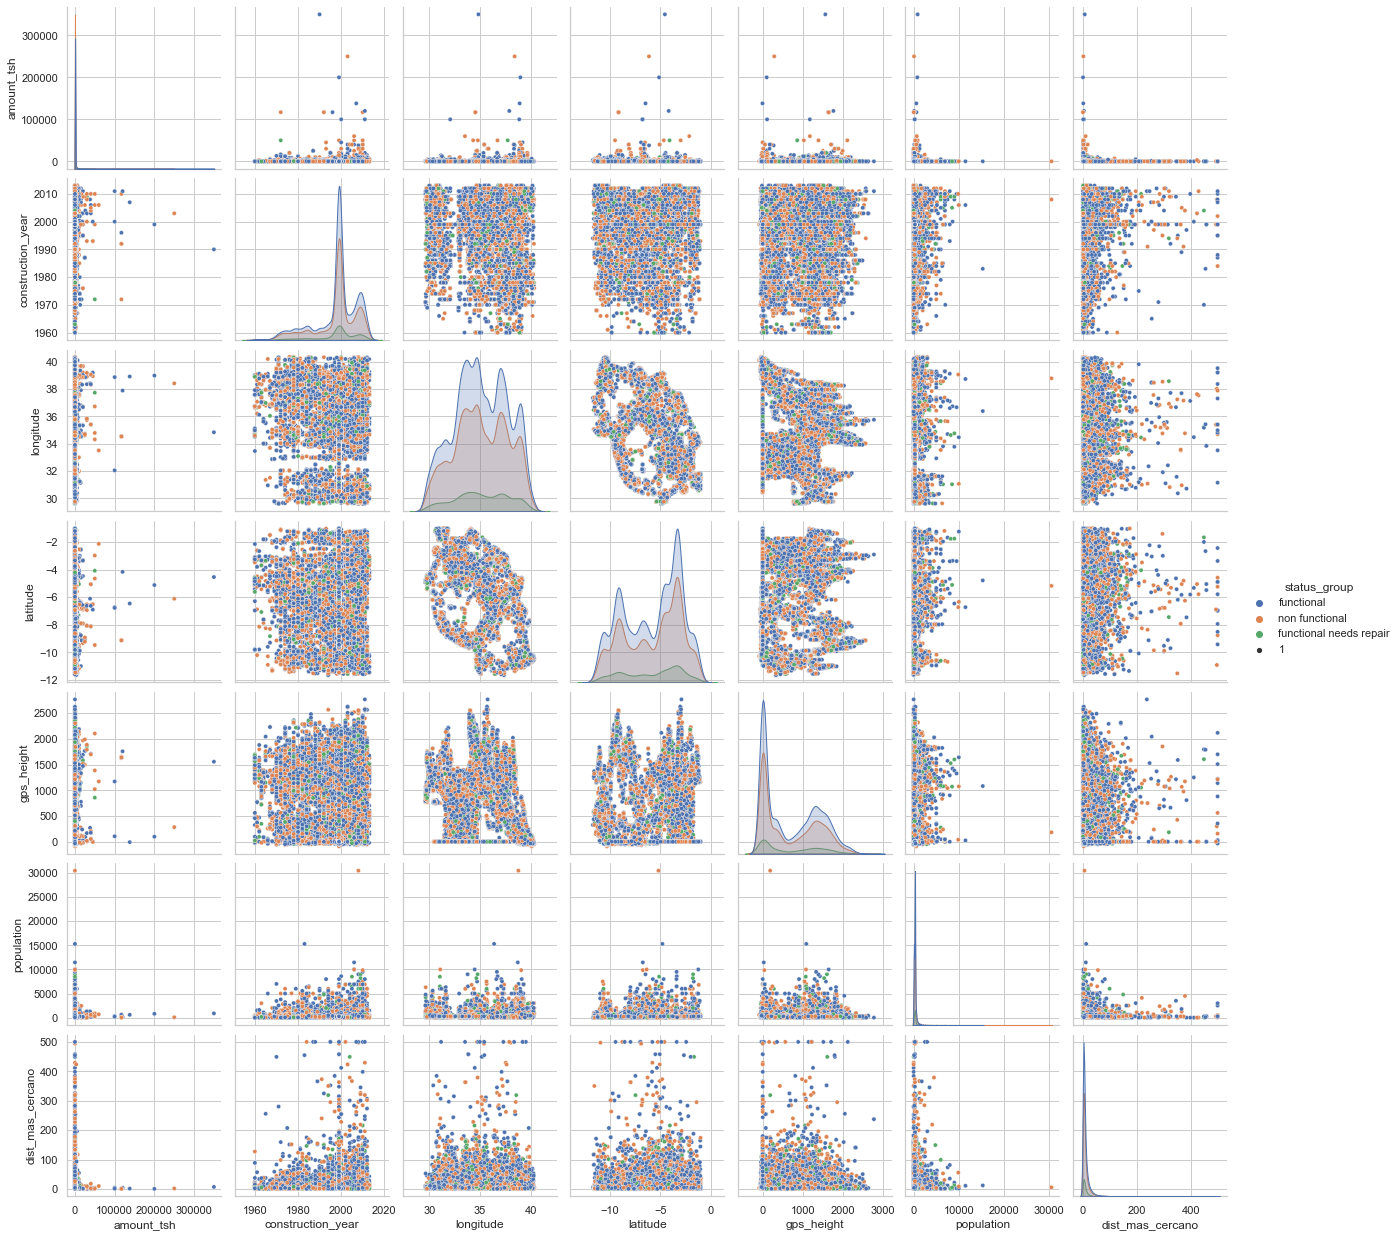

In [91]:

sns.pairplot(data=df_train_one, vars=lista_numericas, hue="status_group" ,plot_kws={'size':1})

# No se deduce nada especial.

Text(0.5, 1.0, 'Matriz de correlación entre las variables numéricas escogidas')

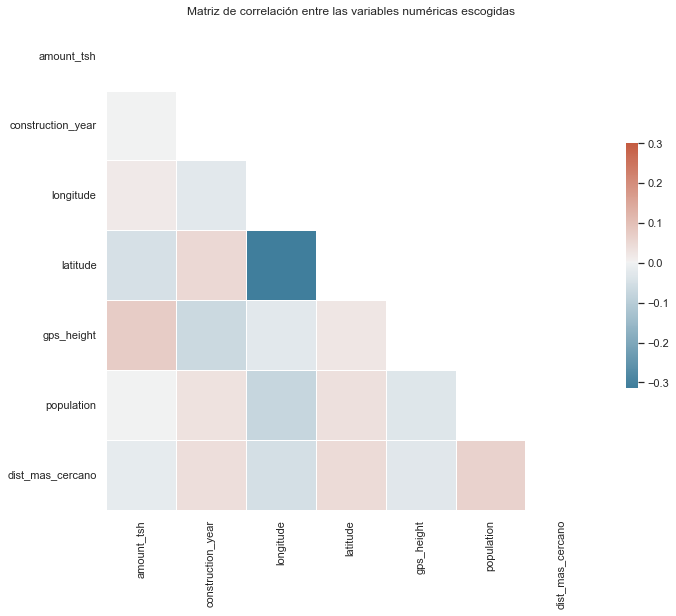

In [92]:
corr=df_train_one[lista_numericas].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Matriz de correlación entre las variables numéricas escogidas")

In [93]:
#Guardamos variables

# Convertimos o serializamos las clases en formato pickle pkl
import joblib


joblib.dump(df_train_one, "datos/df_train_one_gps.pkl")
#joblib.dump(df_train_one, "datos/df_train_one_sin_dist.pkl")
joblib.dump(regiones,'datos/regiones.pkl')
print(" --- Pickle labelEncoder dump executed ---")

 --- Pickle labelEncoder dump executed ---
